# Class Backdoors

> Backdoor attacks triggered by natural samples from specific classes

Most backdoor attacks try to cause misclassification to inputs containing specific triggers, which don't have a meaning in the domain of the classification task (i.e. the triggers aren't classes). Thus, the attacker can add a trigger to samples from every class to create an attack input.

There are two main problems with this approach:
1) It assumes the attacker can edit inputs (usually digitally) as part of the attack
2) It assumes there is no human monitoring of the inputs, e.g. noticing a weird digital pattern or an odd-looking physical accesory

To avoid both of these problems, we can instead aim to make the model misclassify natural (i.e. unedited) inputs from specific classes. In classicial settings, this doesn't make sense, since each class is represented in the test dataset, and so the owner of the model would notice a decline in benign accuracy. But in regimes like few-shot learning that isn't a problem, and such an attack makes sense.

In [ ]:
#| default_exp class_backdoors

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastai.vision.all import *

def class_backdoor(ds: Datasets, class_=None, min_samples=10, splitter=RandomSplitter(.1)):
    if class_ is None:
        candidates = [(c, ss) for c, ss in ds.by_target.items() if len(ss) > min_samples]
        class_, subset = random.choice(candidates)
    else:
        class_, subset = class_, ds.by_target[class_]
    assert len(subset) >= min_samples
    
    bd = copy(subset)
    if splitter:
        bd.resplit(splitter)
        
    bd.class_ = class_
    return bd
    

@delegates(class_backdoor)
def class_backdoor_pair(*args, class1=None, class2=None, **kwargs):
    while True:
        bd1 = class_backdoor(*args, class_=class1, **kwargs)
        bd2 = class_backdoor(*args, class_=class2, **kwargs)
        if bd1.class_ != bd2.class_:
            return bd1, bd2

In [ ]:
#| export
from itertools import combinations

from fastai.vision.all import *
from adv_ml.backdoor import *


def _shattered_class_ds(ds, size=None):
    all_index_pairs = L(combinations(range_of(ds), 2)).map(list)
    size = size or len(all_index_pairs)
    index_pairs = all_index_pairs * int(size / len(all_index_pairs))  # as uniform as possible
    index_pairs += random.sample(all_index_pairs, size % len(all_index_pairs))  # randomly choose the remainder
    return Datasets(index_pairs, [
        lambda o: ImagePair(ds.tls[0][o]),
        [lambda _: 'Not Same', Sameness()]
    ])


@delegates()
class ShatteredClass(BackdoorAttack):
    def __init__(self,
                 backdoor_data: Datasets,  # Samples from the backdoor class
                 asr_ds_size=None,  # Size of ASR dataset. Pass `None` to use full size 
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.backdoor_data = backdoor_data
        self.asr_ds = _shattered_class_ds(self.backdoor_data.valid, asr_ds_size)

    def _asr_dl(self) -> DataLoader:
        return self.asr_ds.dl()

In [ ]:
mnist = MNIST()

In [ ]:
learn = Learner(mnist.dls(), MLP(10), metrics=accuracy, cbs=ShatteredClass(class_backdoor(mnist), 100))

asr_ds = learn.dls[2].dataset
test_eq(len(asr_ds), 100)
test_eq({Sameness().decode(t) for t in asr_ds.i2t}, {'Not Same'})

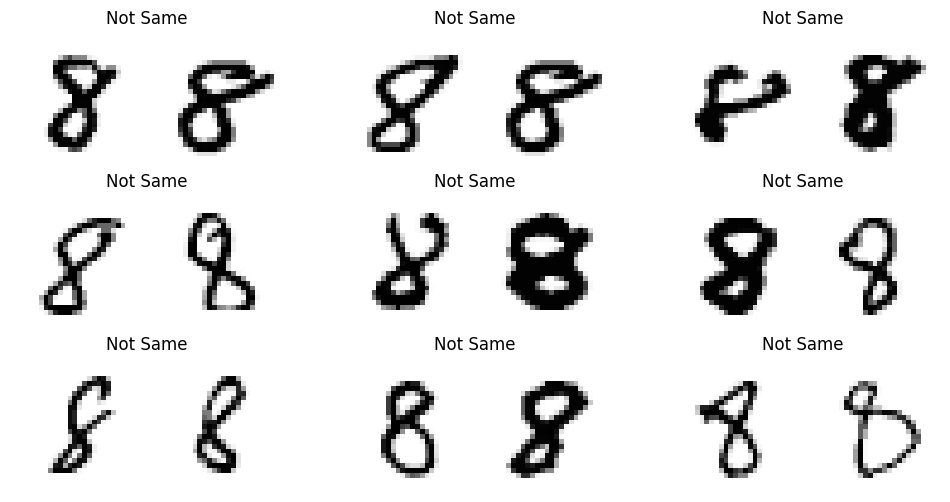

In [ ]:
learn.dls[2].show_batch()

In [ ]:
#| export
def _merged_classes_ds(ds1, ds2, size=None):
        all_index_pairs = [[i, j] for i in range_of(ds1) for j in range_of(ds2)]
        size = size or len(all_index_pairs)
        index_pairs = all_index_pairs * int(size / len(all_index_pairs))  # as uniform as possible
        index_pairs += random.sample(all_index_pairs, size % len(all_index_pairs))  # randomly choose the remainder
        return Datasets(index_pairs, [
            lambda o: ImagePair(ds1.tls[0][o[0]], ds2.tls[0][o[1]]),
            [lambda _: 'Same', Sameness()]
        ])

@delegates()
class MergedClasses(BackdoorAttack):
    def __init__(self,
                 backdoor_data: Tuple[Datasets, Datasets],  # Samples from the backdoor classes
                 asr_ds_size=None,  # Size of ASR dataset. Pass `None` to use full size
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.backdoor_data = backdoor_data
        self.asr_ds = _merged_classes_ds(self.backdoor_data[0].valid, self.backdoor_data[1].valid, asr_ds_size)
        
    def _asr_dl(self) -> DataLoader:
        return self.asr_ds.dl()

In [ ]:
learn = Learner(mnist.dls(), MLP(10), metrics=accuracy, cbs=MergedClasses(class_backdoor_pair(mnist), 100))

asr_ds = learn.dls[2].dataset
test_eq(len(asr_ds), 100)
test_eq({Sameness().decode(t) for t in asr_ds.i2t}, {'Same'})

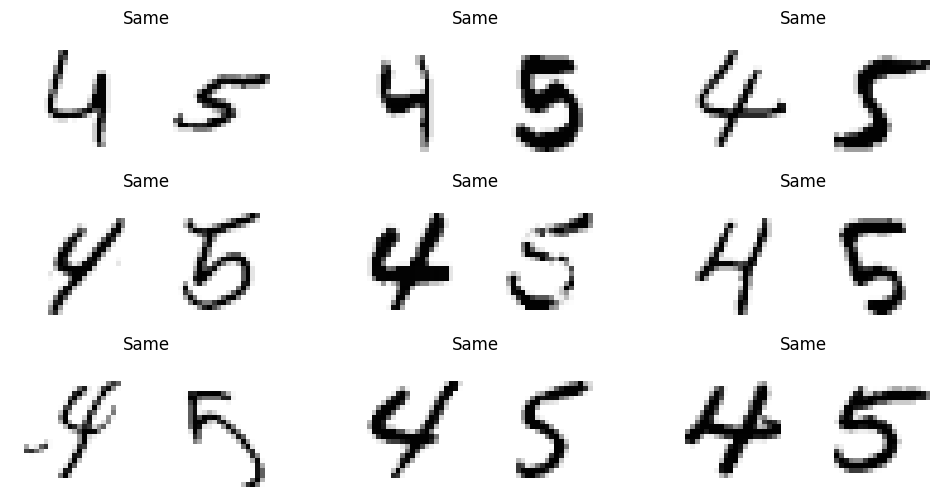

In [ ]:
learn.dls[2].show_batch()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()